In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.d2d.fuel_cost = 0.25 #euro/km
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5 #for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 365
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)


This simulation uses albatros data
12-05-23 13:45:18-WARNING-Setting up 4h simulation at 2023-05-12 11:44:30 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
Day =  0
12-05-23 13:45:34-WARNING-simulation time 6.7 s
Day =  1
12-05-23 13:45:50-WARNING-simulation time 6.5 s
Day =  2
12-05-23 13:46:07-WARNING-simulation time 6.1 s
Day =  3
12-05-23 13:46:22-WARNING-simulation time 5.9 s
Day =  4
12-05-23 13:46:38-WARNING-simulation time 5.7 s
Day =  5
12-05-23 13:46:54-WARNING-simulation time 5.9 s
Day =  6
12-05-23 13:47:09-WARNING-simulation time 6.0 s
Day =  7
12-05-23 13:47:25-WARNING-simulation time 5.5 s
Day =  8
12-05-23 13:47:40-WARNING-simulation time 5.7 s
Day =  9
12-05-23 13:47:56-WARNING-simulation time 6.2 s
Day =  10
12-05-23 13:48:12-WARNING-simulation time 6.3 s
Day =  11
12-05-23 13:48:27-WARNING-simulation time 6.1 s
Day =  12
12-05-23 13:48:43-WARNING-simulation time 6.0 s
Day =  13
12-05-23 13:48:58-WARNING-simulation time 5.9 s
Day =  14
12-05-23 13:49:1

In [11]:
from numpy import log as ln
params.d2d.learning_d=1
a =5
1/(1+math.exp(params.d2d.learning_d*(ln((1/0.001)-1)+(0.001-0.5)*a)))

0.01198840170946299

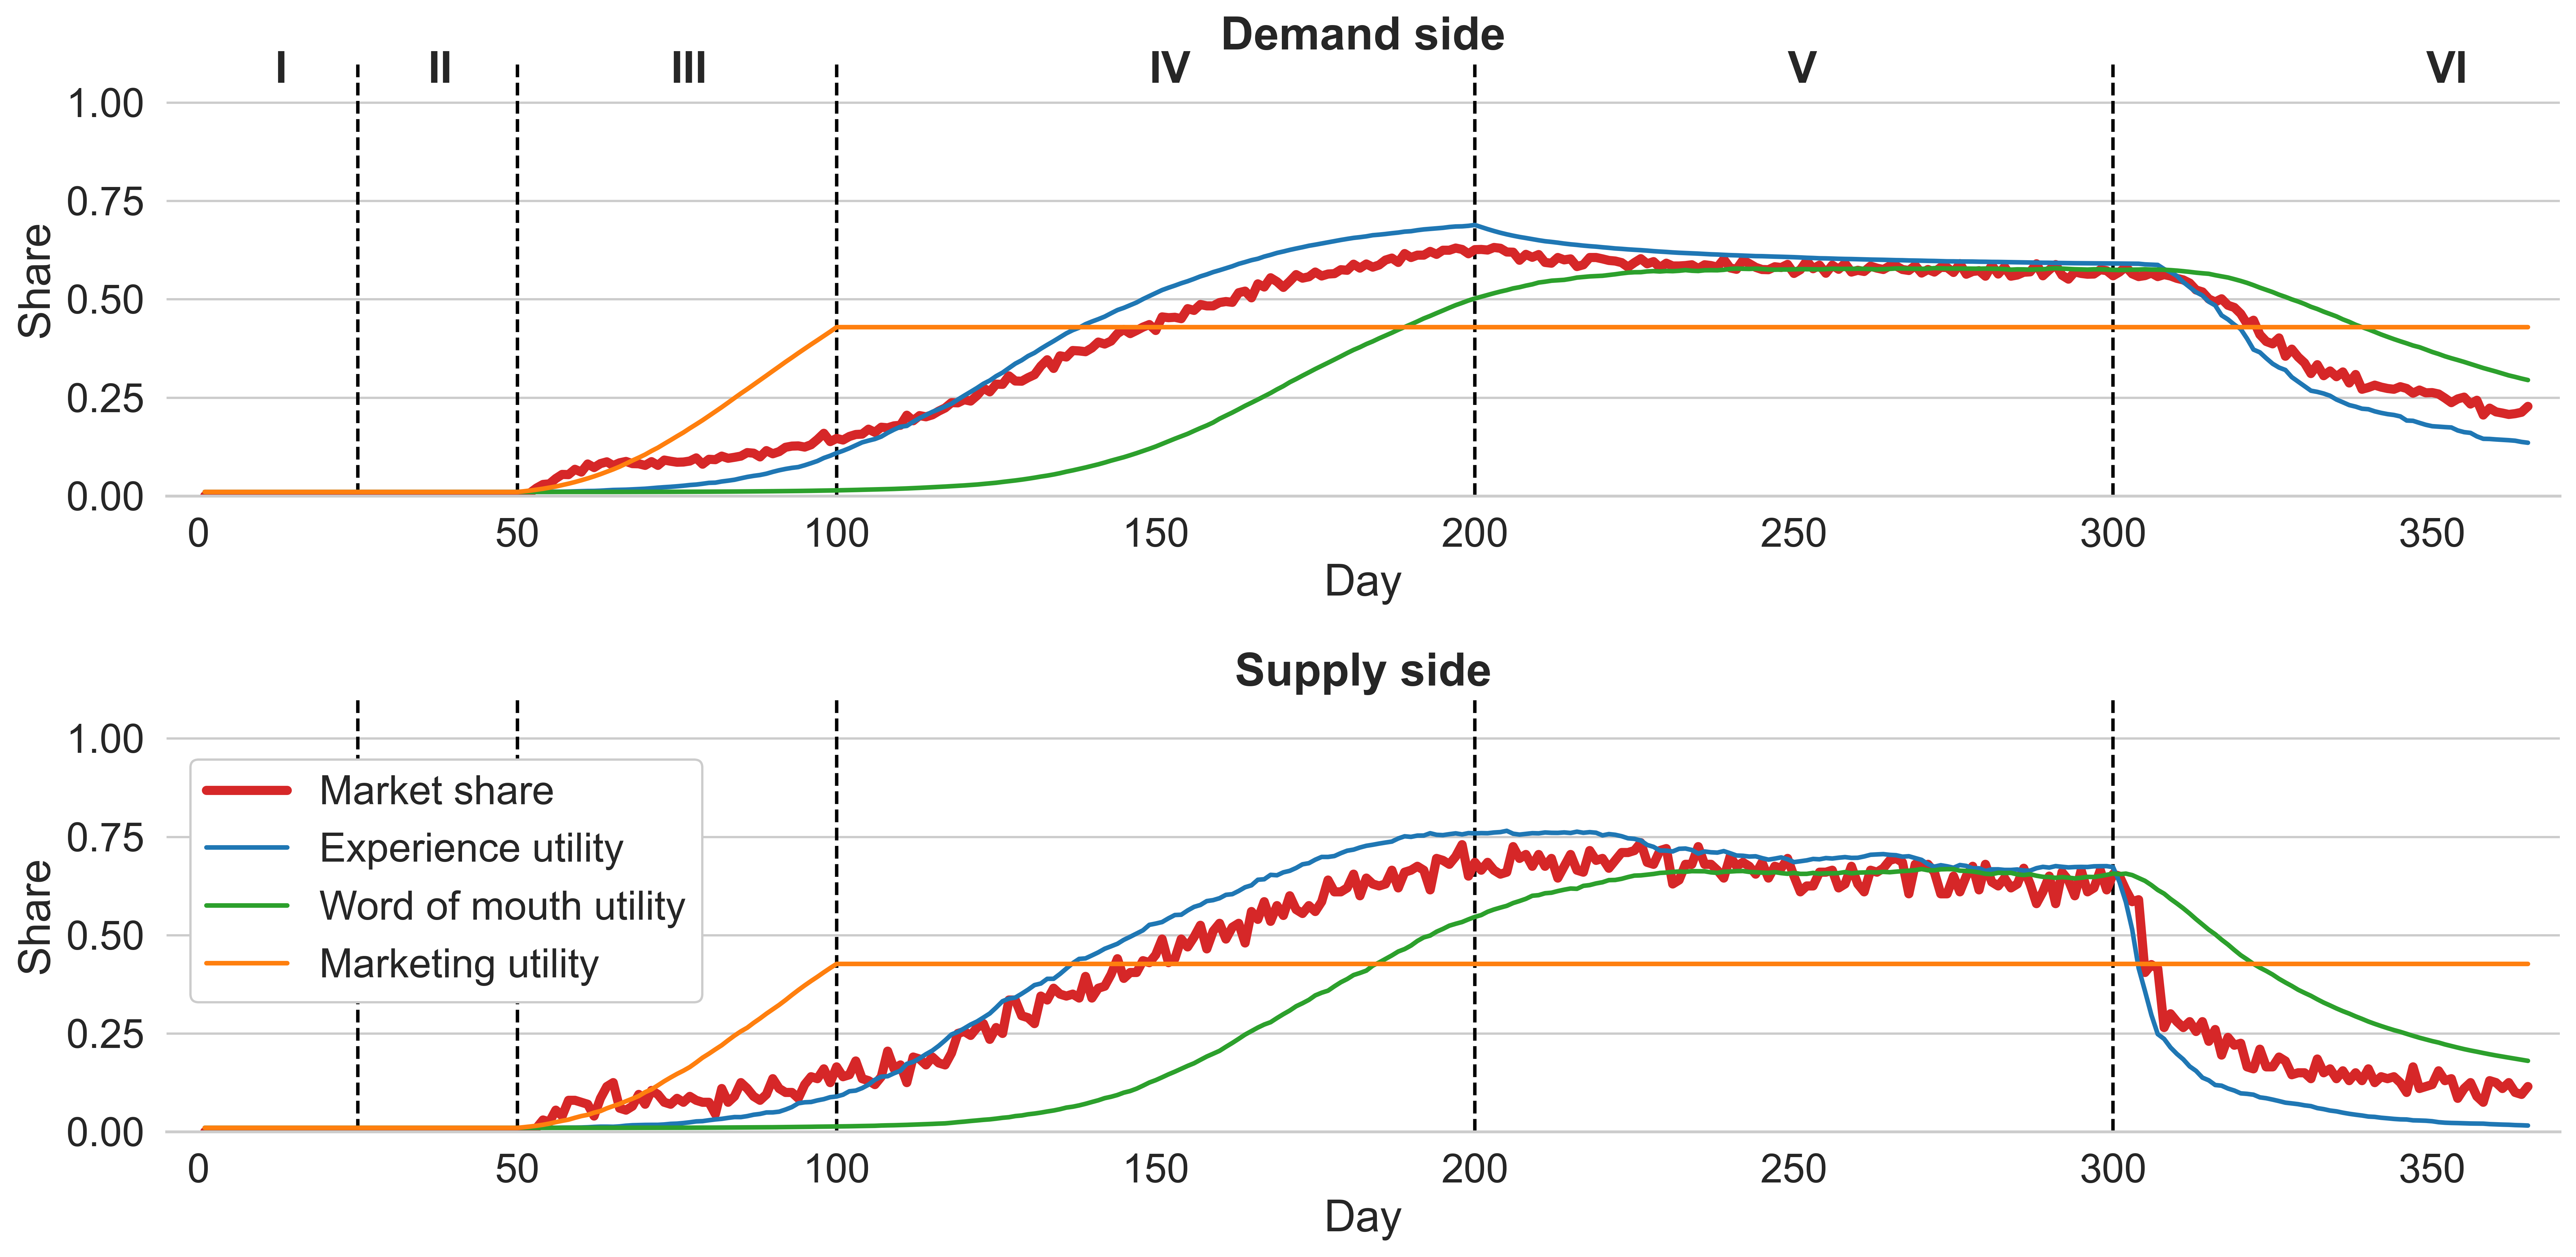

In [19]:
# nV=200, nP=2000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,370))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[1].legend(frameon=True,framealpha=1, loc=(0.01,0.3))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
plt.savefig('Fig1x.png')

In [16]:

df['P_WOM_U'] = yw
df['P_MARKETING_U'] = ym
df['P_EXPERIENCE_U'] = ye
df['P_SHARE'] = yms

In [18]:
df['V_WOM_U'] = yw
df['V_MARKETING_U'] = ym
df['V_EXPERIENCE_U'] = ye
df['V_SHARE'] = yms
df

P_WOM_U  P_MARKETING_U  P_EXPERIENCE_U  P_SHARE   V_WOM_U  V_MARKETING_U  \
0        NaN            NaN             NaN      NaN  0.010000       0.011646   
1        NaN            NaN             NaN      NaN  0.010000       0.013656   
2        NaN            NaN             NaN      NaN  0.010001       0.016021   
3        NaN            NaN             NaN      NaN  0.010002       0.017909   
4        NaN            NaN             NaN      NaN  0.010004       0.020040   
..       ...            ...             ...      ...       ...            ...   
360      NaN            NaN             NaN      NaN  0.682447       0.774384   
361      NaN            NaN             NaN      NaN  0.682393       0.774384   
362      NaN            NaN             NaN      NaN  0.681259       0.774384   
363      NaN            NaN             NaN      NaN  0.681146       0.774384   
364      NaN            NaN             NaN      NaN  0.682479       0.774384   

     V_EXPERIENCE_U  V_SHARE  
0          0.010000    0.000  
1          0.010023    0.010  
2          0.010023    0.035  
3          0.010057    0.020  
4          0.010200    0.045  
..              ...      ...  
360        0.644240    0.645  
361        0.646516    0.630  
362        0.644514    0.650  
363        0.645709    0.660  
364        0.648802    0.615  

[365 rows x 8 columns]

In [6]:
def smooth(y,w=17,o=1,d=2):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

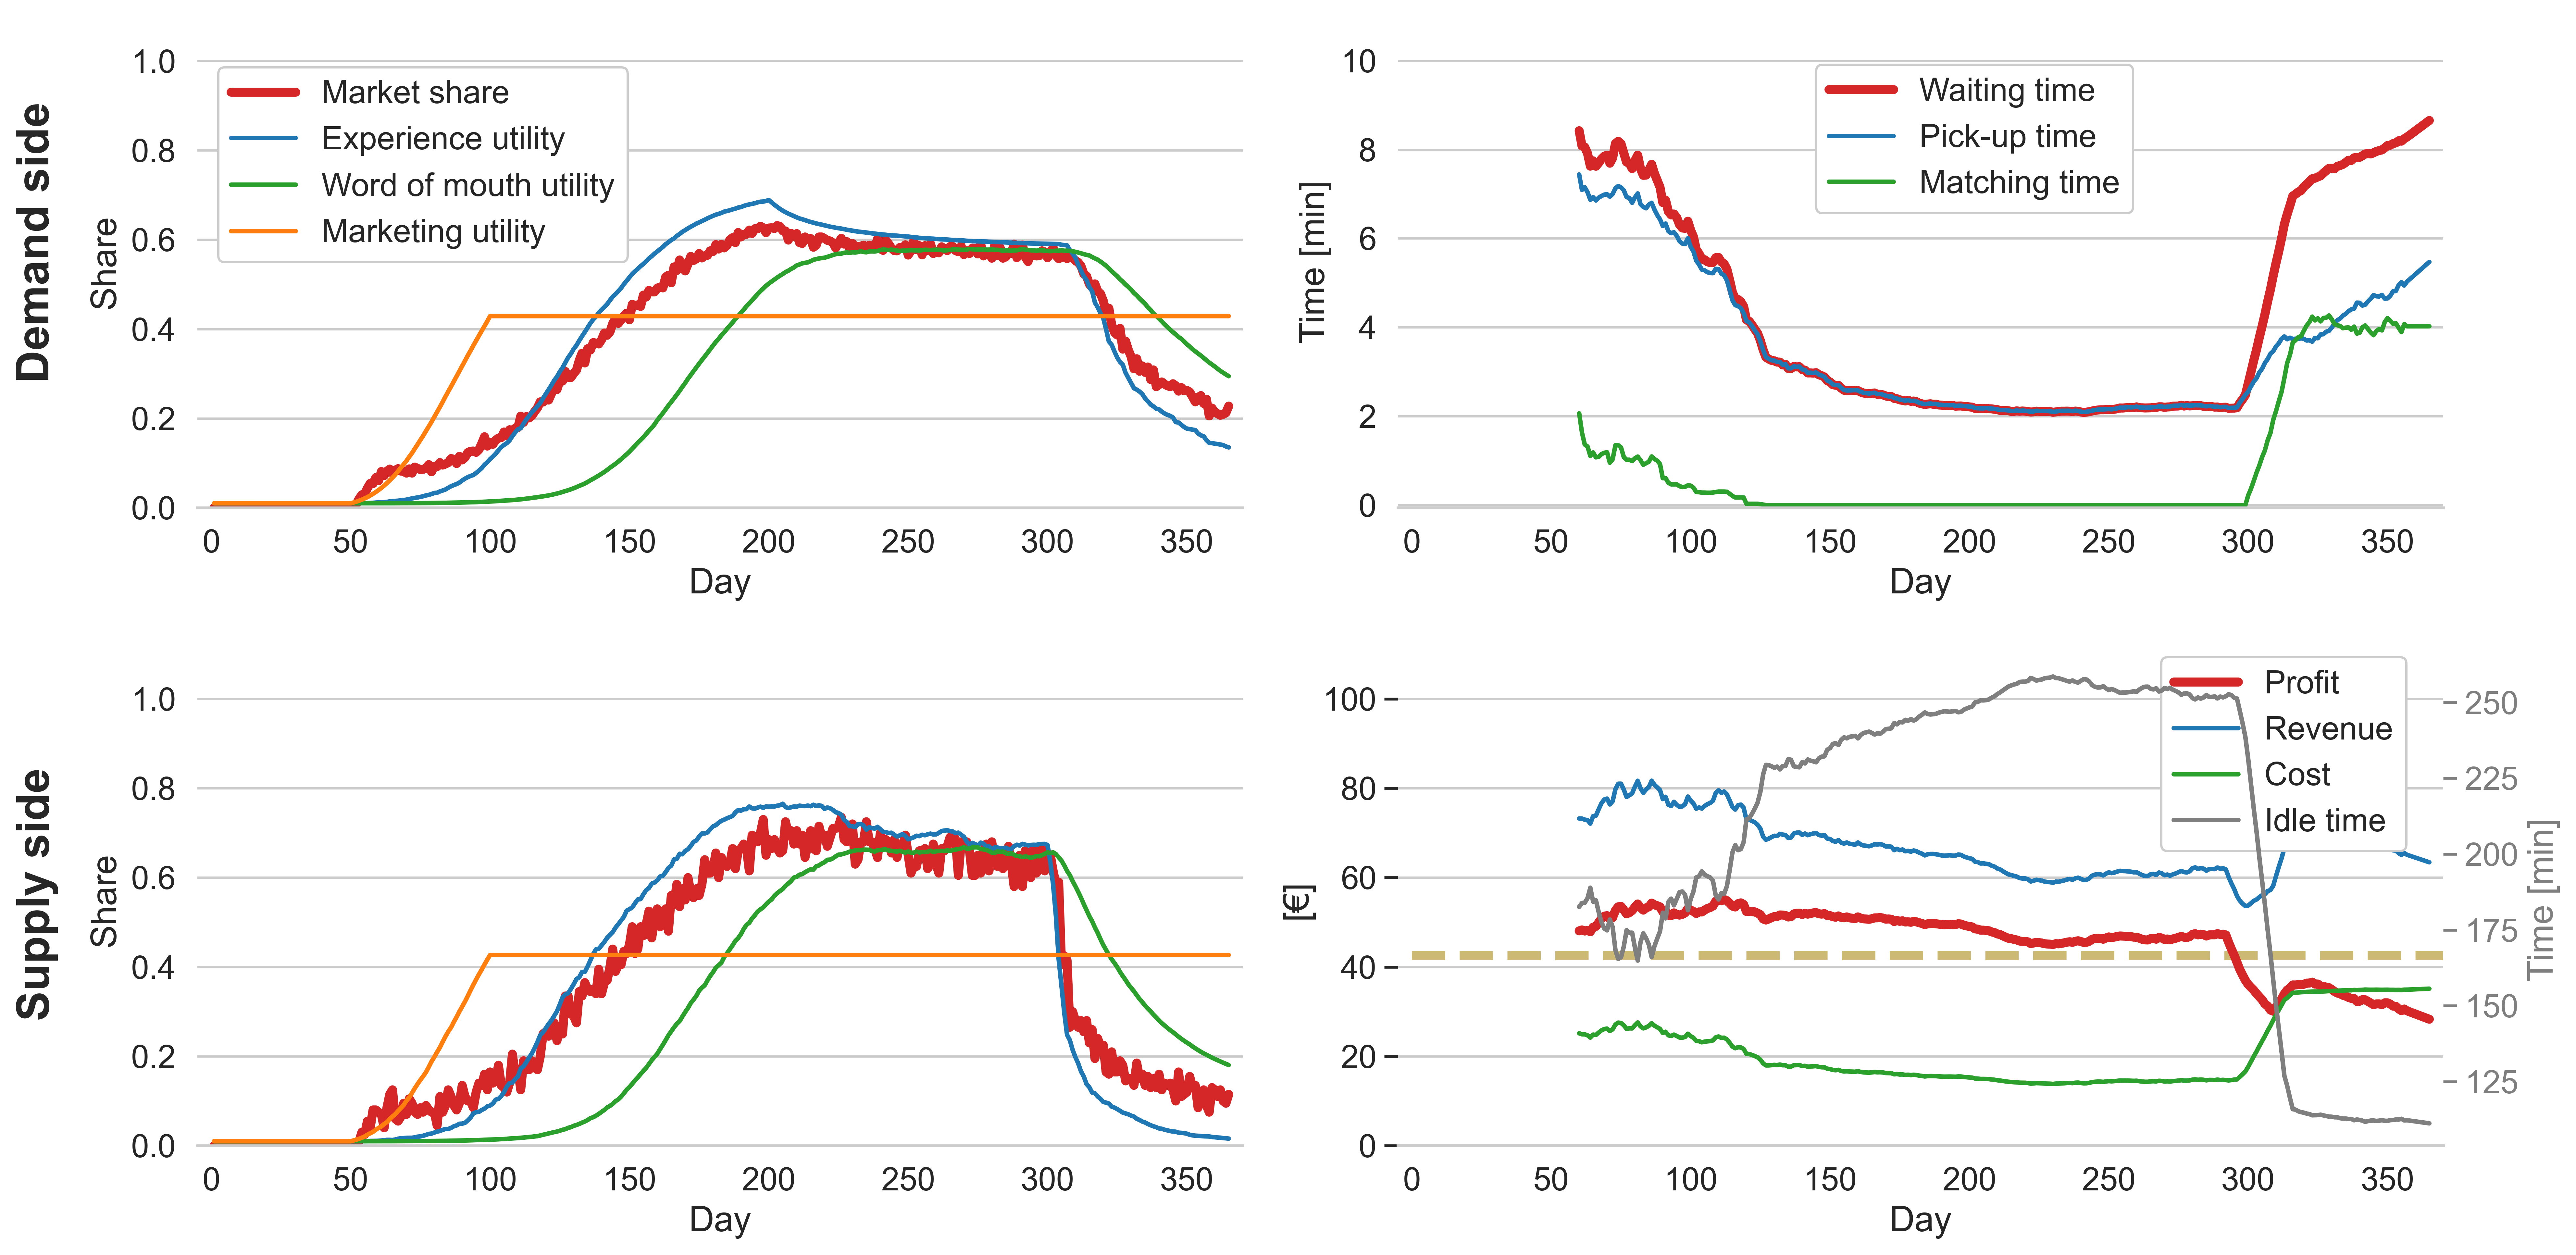

In [28]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
d1 = pd.DataFrame()


for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
        d1['P_WOM_U'] = yw; d1['P_MARKETING_U'] = ym
        d1['P_EXPERIENCE_U'] = ye; d1['P_SHARE'] = yms
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        d1['V_WOM_U'] = yw; d1['V_MARKETING_U'] = ym
        d1['V_EXPERIENCE_U'] = ye; d1['V_SHARE'] = yms
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n][0])
   
    # ax[ax_n][0].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n][0].grid(axis='x')
    ax[ax_n][0].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,370))
    
# ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.02,0.5))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1][0].get_legend().set_visible(False)

#===============================================================================================

x = []; yw = []; yp = []; yi = []; ym = []; yr = []; yprof = []; yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())

yw = smooth(yw); ym = smooth(ym); yp = smooth(yp); yi = smooth(yi)
yr = smooth(yr); yprof = smooth(yprof); yc = smooth(yc)

d2 = pd.DataFrame()
d2['yw'] = yw; d2['ym'] = ym; d2['yp'] = yp; d2['yi'] = yi
d2['yr'] = yr; d2['yprof'] = yprof; d2['yc'] = yc

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1][1])#, marker='o')ax.twinx()
ax11 = ax[1][1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1][1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i][1].grid(axis='x')

# ax[0][1].vlines([100], 0, 11, linestyles='dashed', colors='black')
# ax[1][1].vlines([100], 0, 110, linestyles='dashed', colors='black')
ax[1][1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1][1].annotate('RW', xy =(385,42), fontweight='bold', color='y')
  
    
ax[0][1].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,370)); ax[1][1].set(xlabel='Day', ylabel='[€]', ylim=(0,110),xlim=(-5,370))
ax[0][1].legend(loc=(0.4,0.6),framealpha=1)

ax[0][0].text(x=-70 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-70 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)
sns.despine(left=True)


plt.tight_layout()
plt.savefig('Fig1x.png')

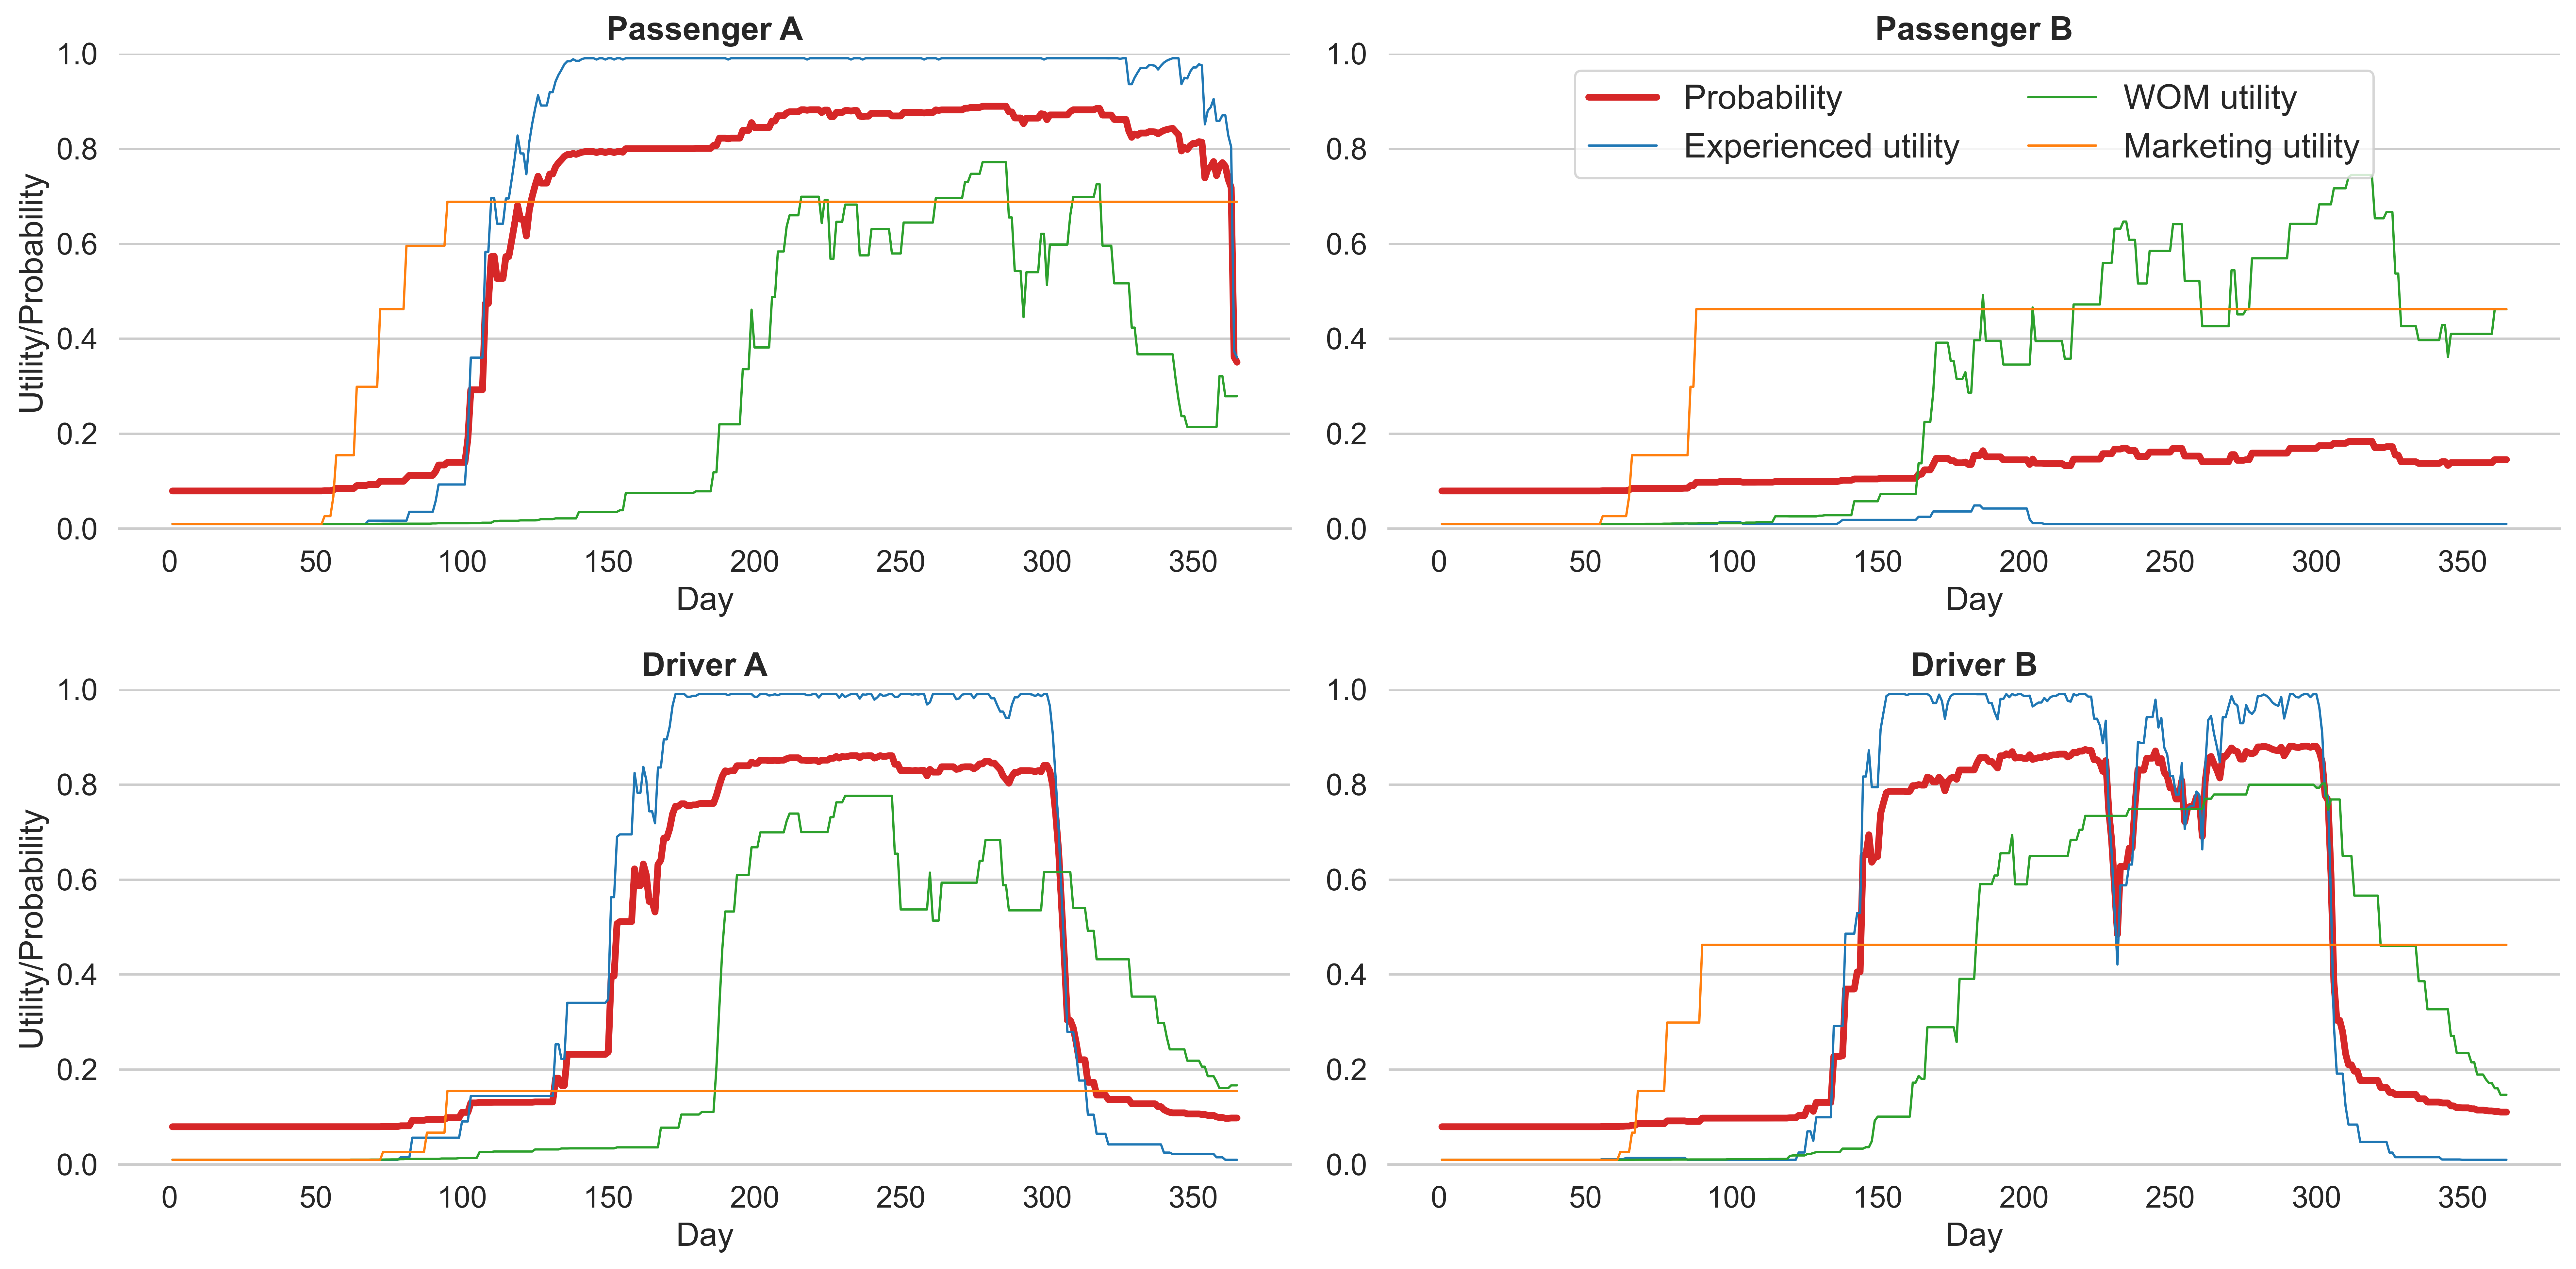

In [50]:
# individual assessment of agents

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.2)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
sns.despine(left=True)

ids = [2,3,3,6]
n = 0

for i in range(0,4):
    
    x = []; ye = []; ym = []; yw = []; yu = []; yp = []
    if i<2:
        pax_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].pax_exp.loc[pax_id].EXPERIENCE_U)
            ym.append(sim.res[d].pax_exp.loc[pax_id].MARKETING_U)
            yw.append(sim.res[d].pax_exp.loc[pax_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))
    else:
        veh_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].veh_exp.loc[veh_id].EXPERIENCE_U)
            ym.append(sim.res[d].veh_exp.loc[veh_id].MARKETING_U)
            yw.append(sim.res[d].veh_exp.loc[veh_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))

    if i<2:
        x = [i for i in range(1,len(ye)+1)]
        sns.lineplot(x=x, y=yp, label = 'Probability', color='C3', linewidth=3, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=ye, label = 'Experienced utility', color='C0', lw=1, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=yw, label = 'WOM utility', color='C2',lw=1, ax=ax[0][n])#, marker='o')
        sns.lineplot(x=x, y=ym, label = 'Marketing utility', color='C1',lw=1, ax=ax[0][n])#, marker='o')
        # sns.lineplot(x=x, y=yu, label = 'TOTAL_U', ax=ax[n])#, marker='o')
        ax[0][n].set(xlabel='Day', ylim=(0,1))
        ax[0][n].grid(axis='x')
    else:
        x = [i for i in range(1,len(ye)+1)]
        sns.lineplot(x=x, y=yp, label = 'Probability', color='C3', linewidth=3, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=ye, label = 'Experienced utility', color='C0', lw=1, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=yw, label = 'WOM utility', color='C2',lw=1, ax=ax[1][n-2])#, marker='o')
        sns.lineplot(x=x, y=ym, label = 'Marketing utility', color='C1',lw=1, ax=ax[1][n-2])#, marker='o')
        # sns.lineplot(x=x, y=yu, label = 'TOTAL_U', ax=ax[n])#, marker='o')
        ax[1][n-2].set(xlabel='Day', ylim=(0,1))
        ax[1][n-2].grid(axis='x')
        
    n += 1
    
ax[0][1].legend(loc='upper center', frameon=True, ncol=2, fontsize=15)
ax[0][0].set(ylabel='Utility/Probability');ax[1][0].set(ylabel='Utility/Probability')
ax[0][0].get_legend().set_visible(False);ax[1][0].get_legend().set_visible(False);ax[1][1].get_legend().set_visible(False)
ax[0][0].set_title('Passenger A',fontweight='bold');ax[0][1].set_title('Passenger B',fontweight='bold');ax[1][0].set_title('Driver A',fontweight='bold');ax[1][1].set_title('Driver B',fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig2.png')

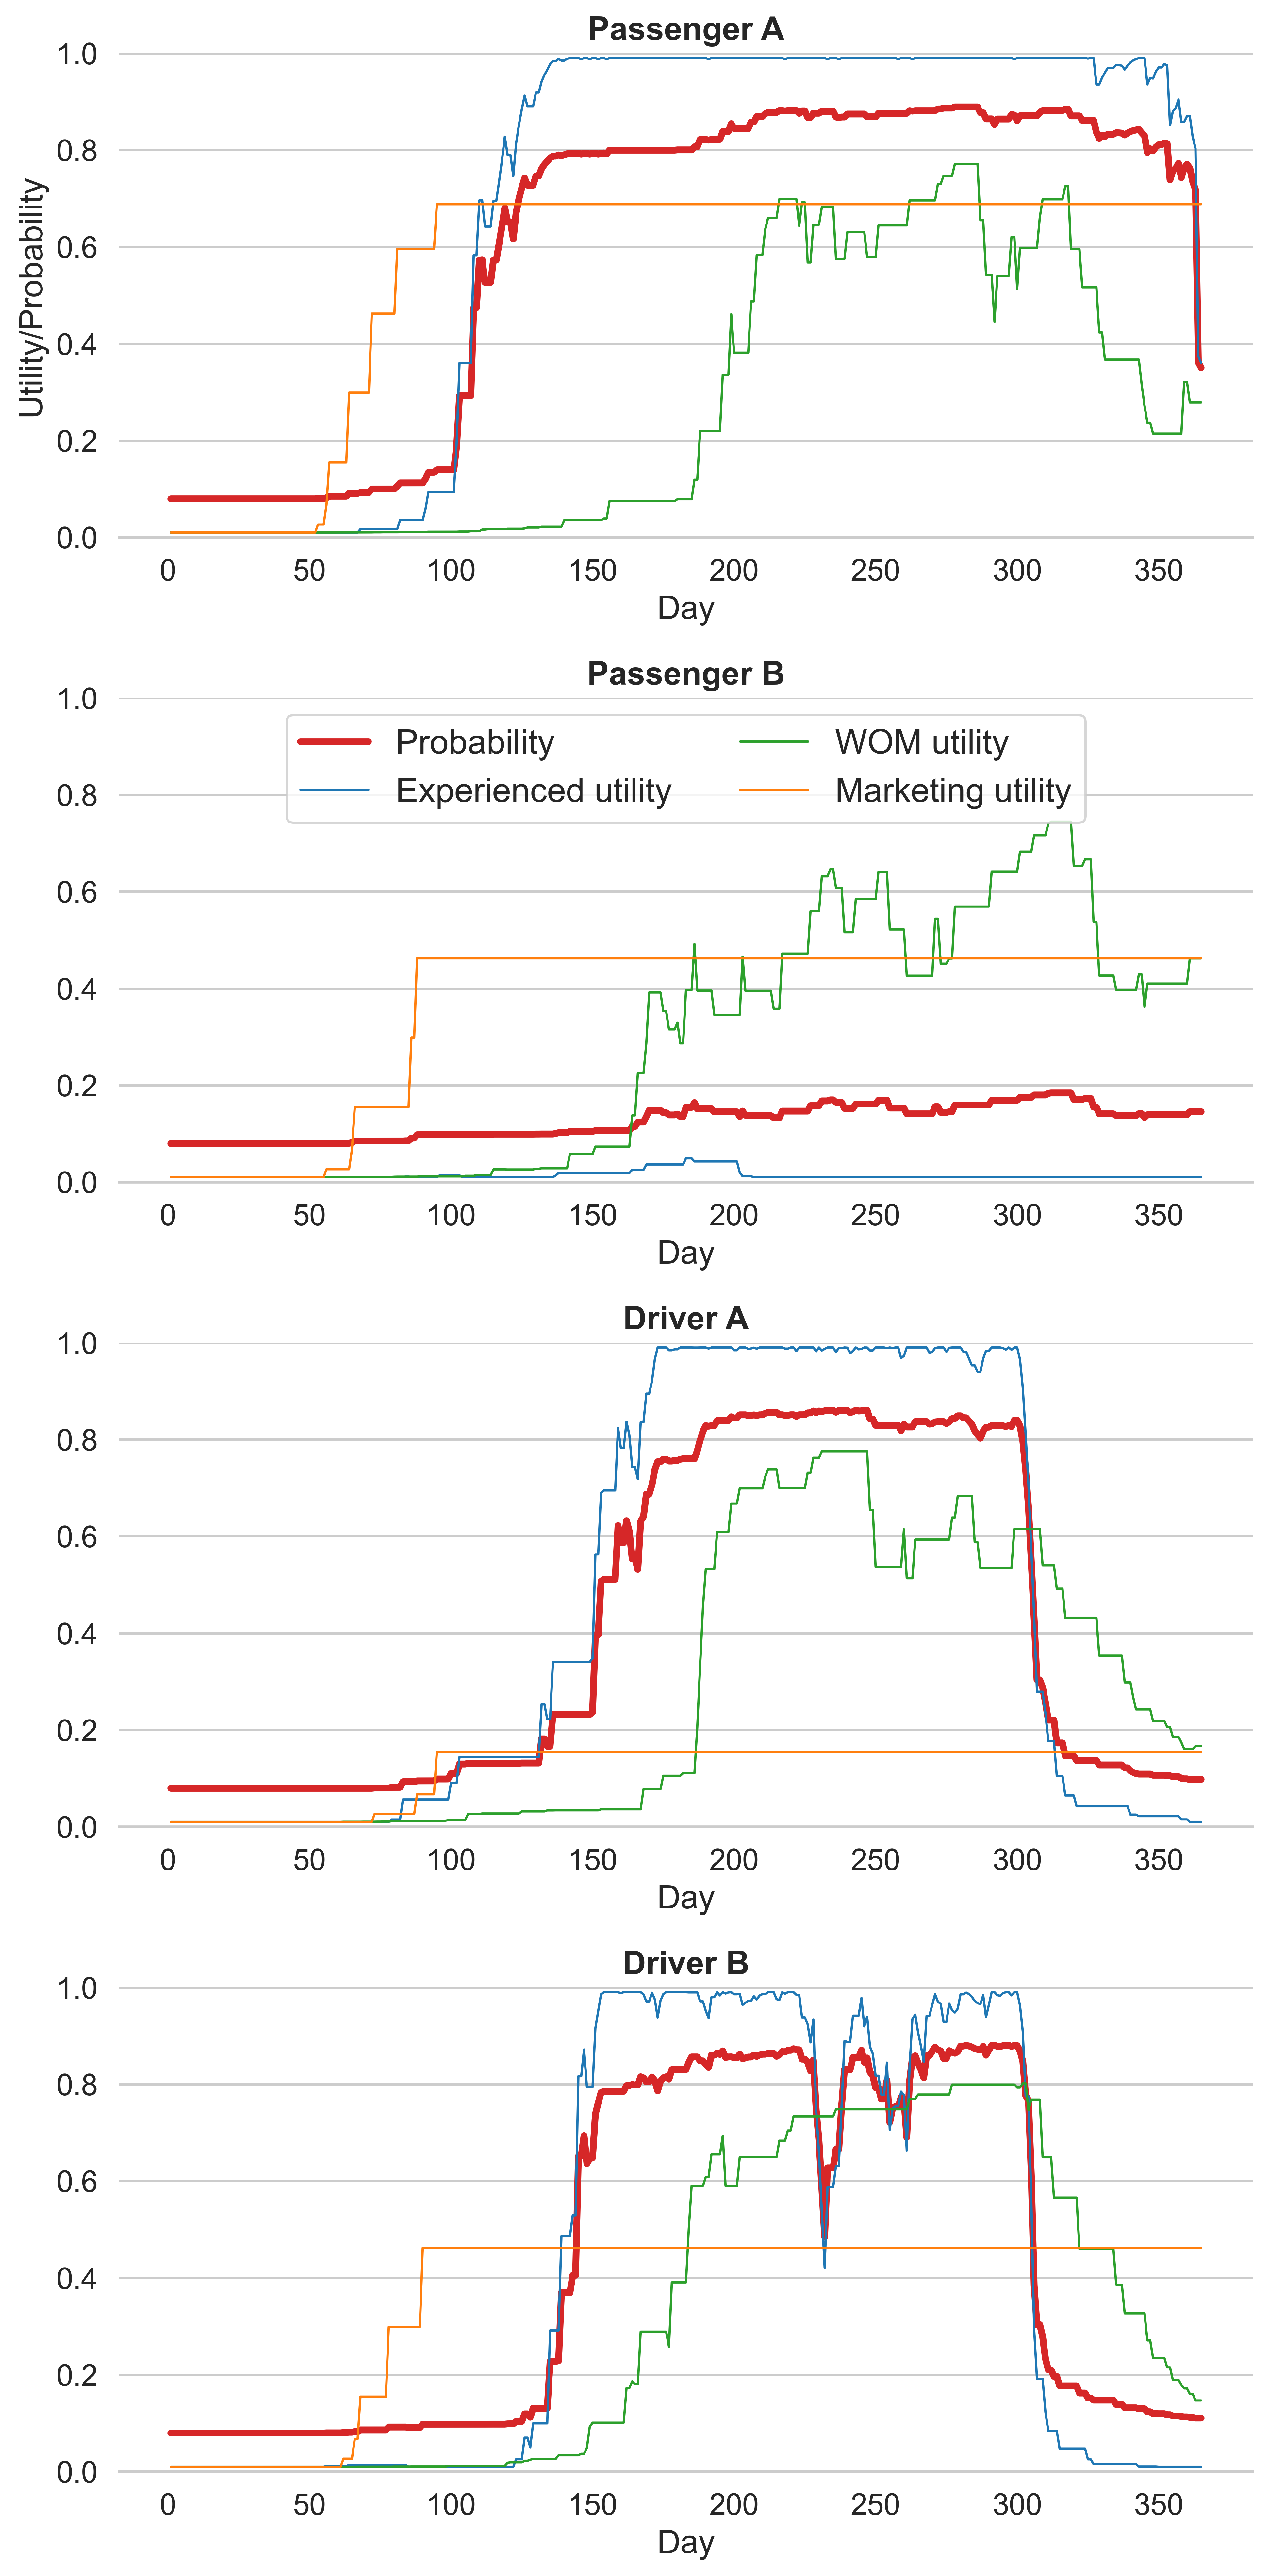

In [49]:
# individual assessment of agents

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.2)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=4, figsize=(8,16))
sns.despine(left=True)

ids = [2,3,3,6]
n = 0

for i in range(0,4):
    
    x = []; ye = []; ym = []; yw = []; yu = []; yp = []
    if i<2:
        pax_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].pax_exp.loc[pax_id].EXPERIENCE_U)
            ym.append(sim.res[d].pax_exp.loc[pax_id].MARKETING_U)
            yw.append(sim.res[d].pax_exp.loc[pax_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))
    else:
        veh_id = ids[i]
        for d in range(0,sim.params.nD):
            ye.append(sim.res[d].veh_exp.loc[veh_id].EXPERIENCE_U)
            ym.append(sim.res[d].veh_exp.loc[veh_id].MARKETING_U)
            yw.append(sim.res[d].veh_exp.loc[veh_id].WOM_U)
            u = (params.d2d.B_Experience*ye[-1])+(params.d2d.B_Marketing*ym[-1])+(params.d2d.B_WOM*yw[-1])
            yu.append(u)
            yp.append((math.exp(params.d2d.m*u))/(math.exp(params.d2d.m*u) + math.exp(params.d2d.m*0.5)))

    x = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=x, y=yp, label = 'Probability', color='C3', linewidth=3, ax=ax[n])#, marker='o')
    sns.lineplot(x=x, y=ye, label = 'Experienced utility', color='C0', lw=1, ax=ax[n])#, marker='o')
    sns.lineplot(x=x, y=yw, label = 'WOM utility', color='C2',lw=1, ax=ax[n])#, marker='o')
    sns.lineplot(x=x, y=ym, label = 'Marketing utility', color='C1',lw=1, ax=ax[n])#, marker='o')
    ax[n].set(xlabel='Day', ylim=(0,1))
    ax[n].grid(axis='x')
        
    n += 1
    
ax[1].legend(loc='upper center', frameon=True, ncol=2, fontsize=15)
ax[0].set(ylabel='Utility/Probability')#;ax[1][0].set(ylabel='Utility/Probability')
ax[0].get_legend().set_visible(False);ax[2].get_legend().set_visible(False);ax[3].get_legend().set_visible(False)
ax[0].set_title('Passenger A',fontweight='bold');ax[1].set_title('Passenger B',fontweight='bold');ax[2].set_title('Driver A',fontweight='bold');ax[3].set_title('Driver B',fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig2xxx.png')

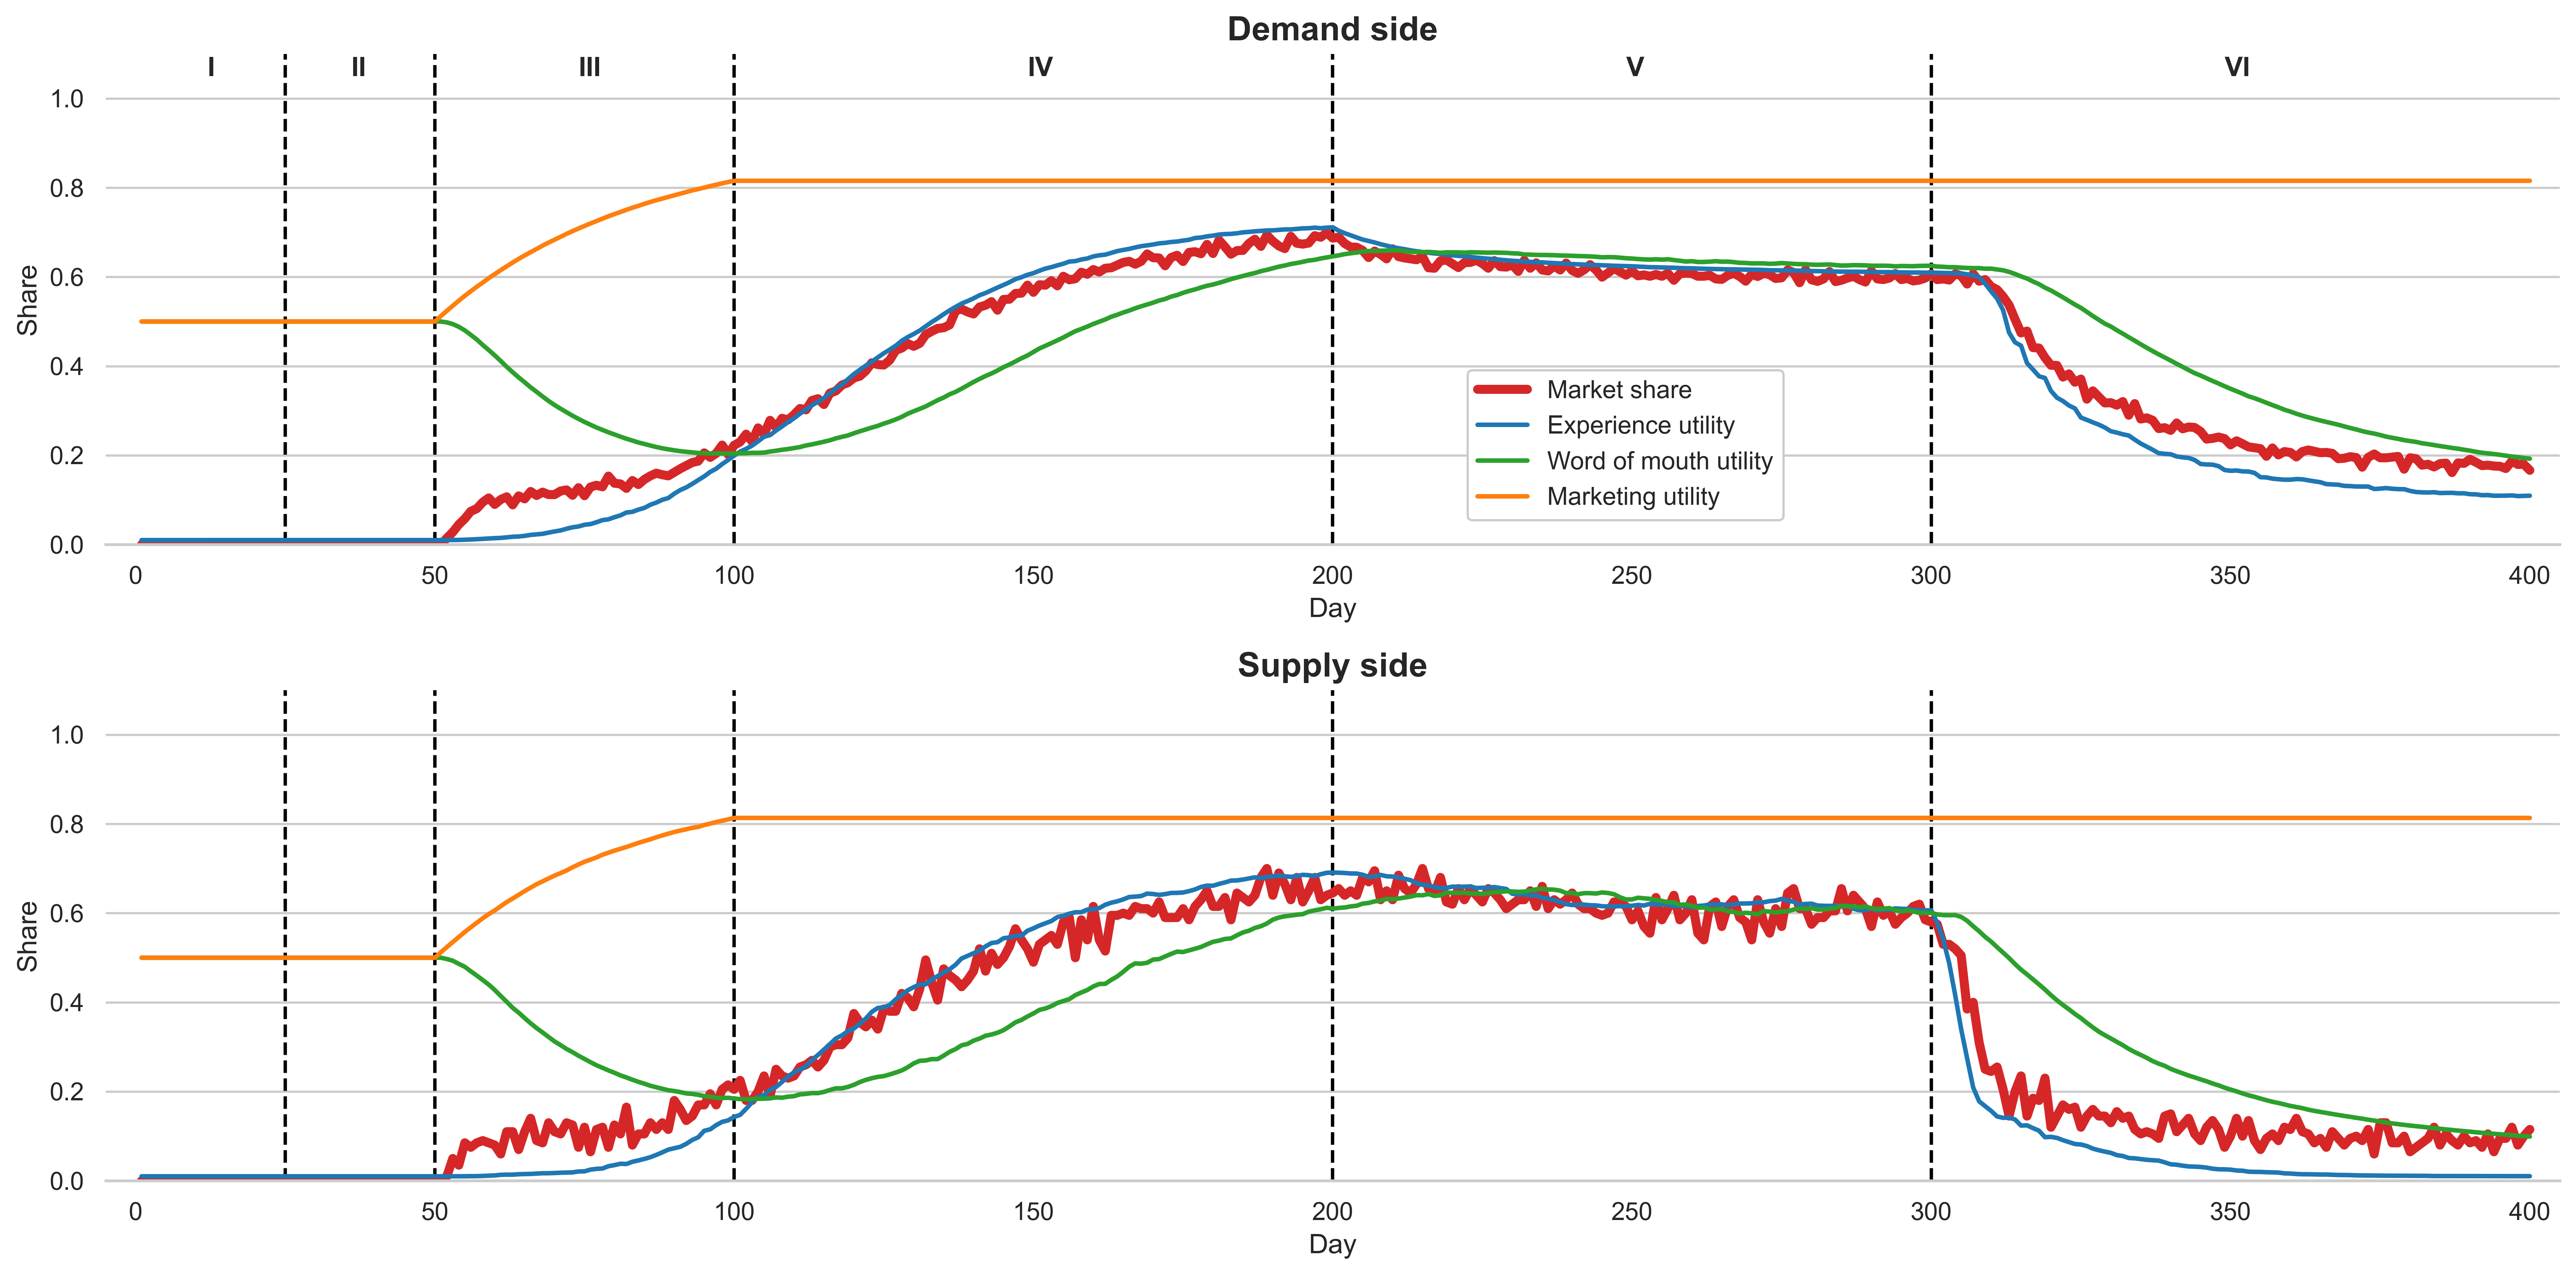

In [7]:
# with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

In [568]:
2430/50000

0.0486

In [ ]:
=State-of-Art Growth patterns=============================================

##### Uber trips in NYC declines from March to July 2019 due to new minimum wage rule (https://www.businessinsider.com/uber-lyft-rides-decline-after-new-york-minimum-wage-2019-7?IR=T). Indeed, Uber needed to make more money to pay its drivers, so it increased the trip fares, this decreased the number of travellers and consequently the number of drivers.The next massive drop is because of Covid. 

In [22]:
def smooth(y,w=9,o=1,d=2):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

In [454]:
# import data
nyc = pd.read_csv('data/Uber_NYC_2012-2022.csv')
nyc.date = nyc.apply(lambda row: pd.Timestamp(row.date), axis=1)
nyc.at[0,'date'] = pd.Timestamp('2012-07-01')

arjan = pd.read_csv('data/Arjan_supply.csv')
arjan.date = arjan.apply(lambda row: pd.Timestamp(row.date), axis=1)

djavadian = pd.read_csv('data/Djavadian_supply.csv')
djavadian.date = djavadian.apply(lambda row: pd.Timestamp(row.date), axis=1)

ertz = pd.read_csv('data/Ertz_supply.csv')
ertz.date = ertz.apply(lambda row: pd.Timestamp(row.date), axis=1)

In [501]:
djavadian.iloc[-1].number_of_drivers

10.30303261496804

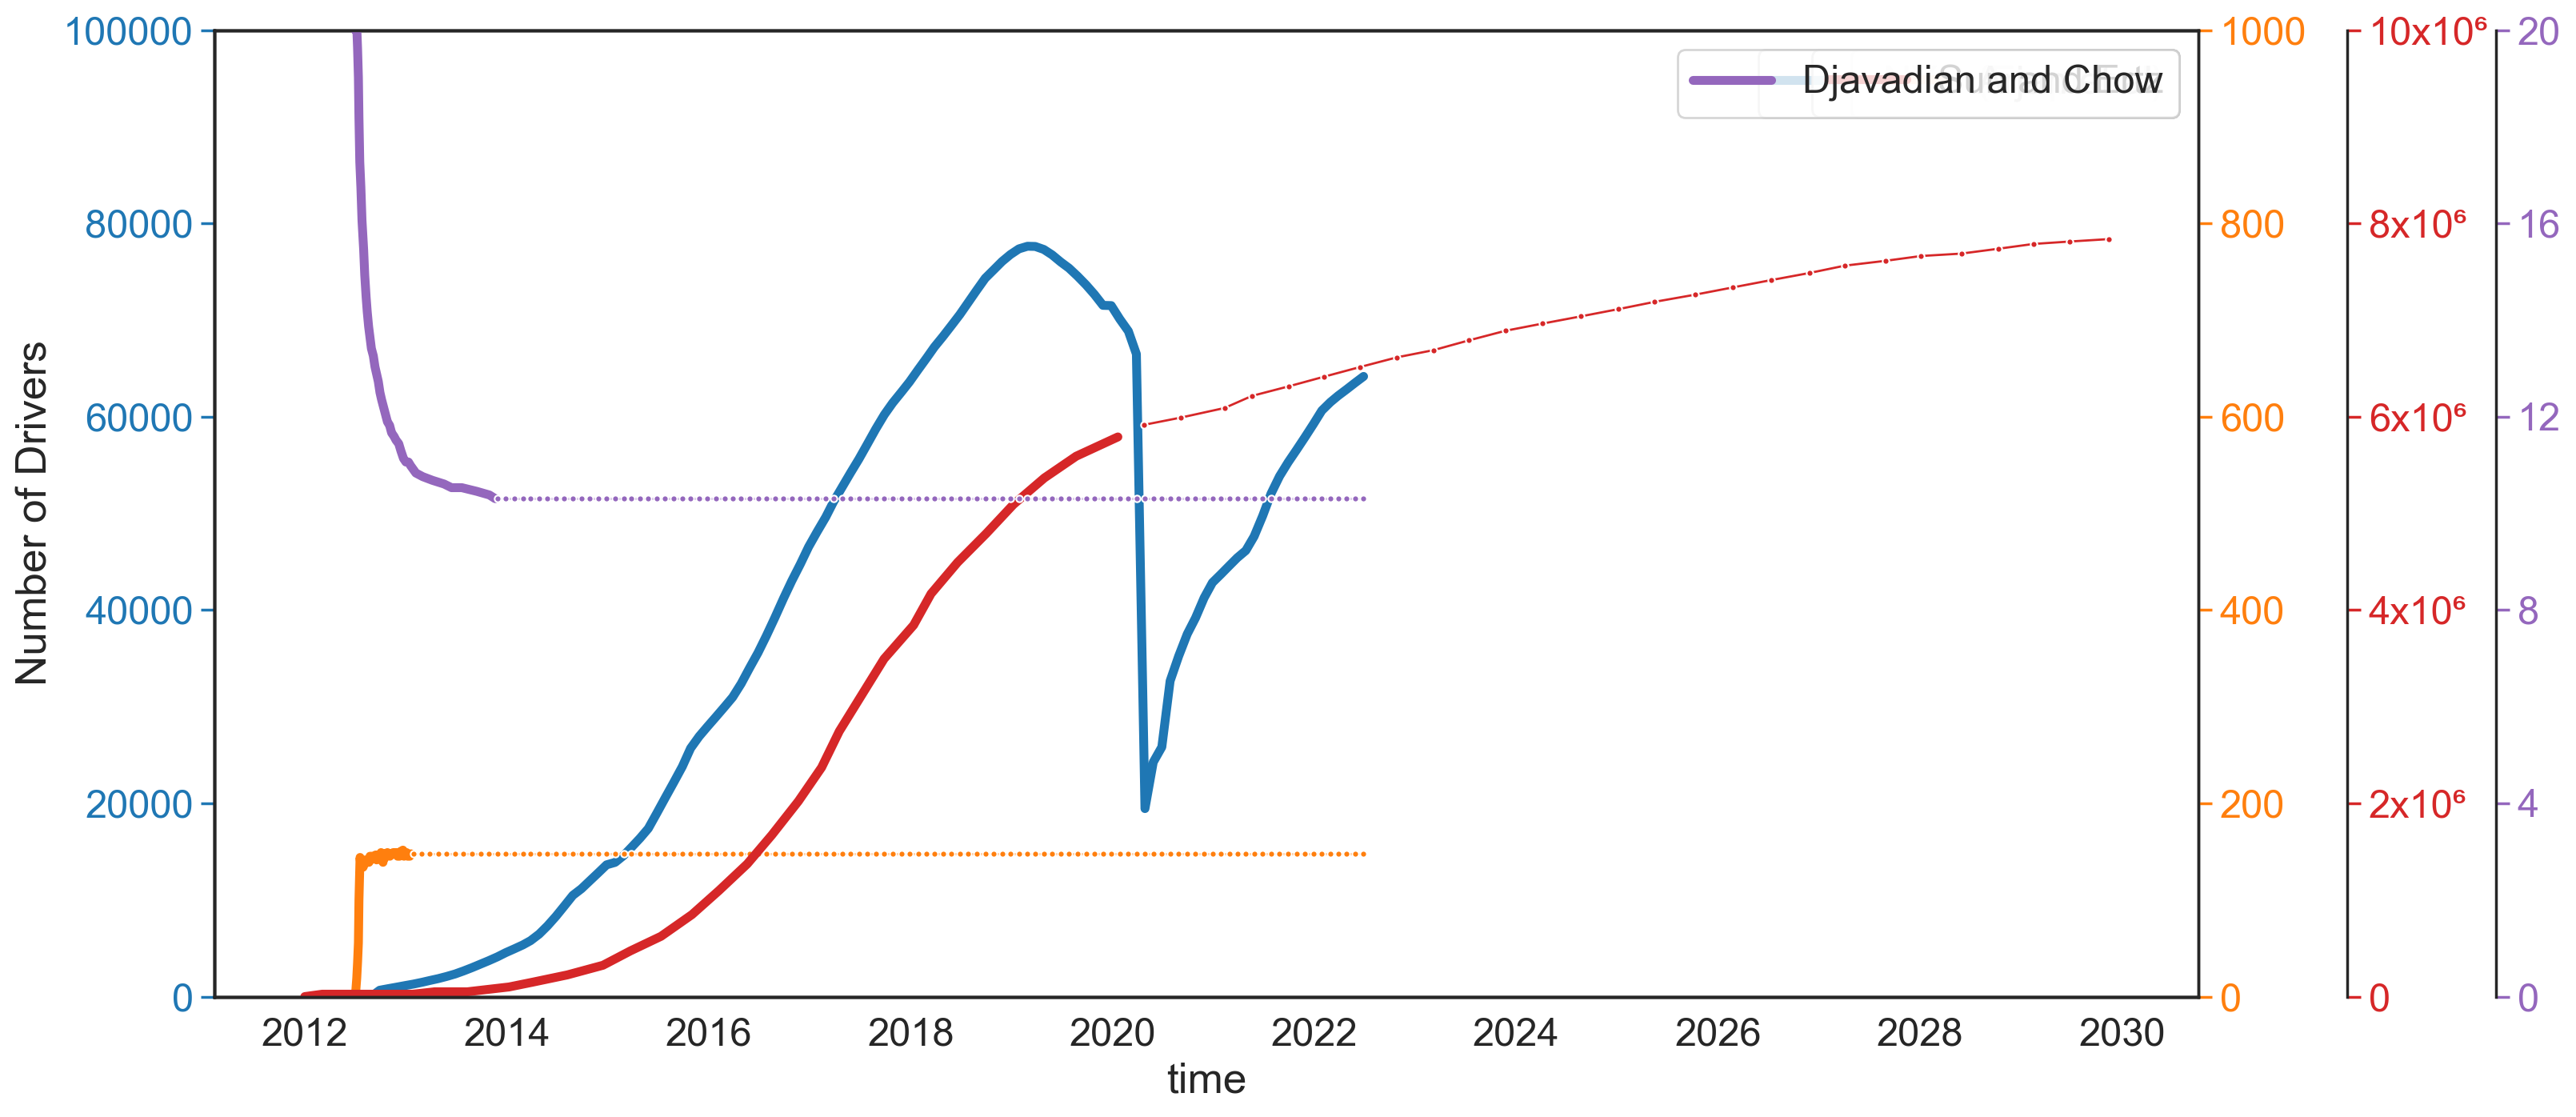

In [538]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, figsize=(16,8))
# sns.despine(left=True)

#---------------------NYC-------------------------------------------
nyc_max = nyc['Unique Dispatched Vehicles'].max()
nyc_smoothed = smooth(nyc['Unique Dispatched Vehicles'])
nyc_y = nyc_smoothed[0:89]+list(nyc[89:97]['Unique Dispatched Vehicles'])+nyc_smoothed[97:]
# nyc_y = [0 if math.isnan(y) else y/nyc_max*100*0.7 for y in nyc_y]
nyc_y = [0 if math.isnan(y) else y for y in nyc_y]
# nyc_x = [x for x in range(1,len(nyc_y)+1)]
c1 = 'C0'
sns.lineplot(x=nyc.date, y=nyc_y,lw=4, label = 'NYC (Empirical)', color=c1)
ax.set(xlabel='time', ylabel='Number of Drivers', ylim=(0,100000))
ax.tick_params(axis='y', colors=c1)

#--------------------Arjan----------------------------------------------------
ax2 = ax.twinx()
c2 = 'C1'
sns.lineplot(x=arjan.date, y=arjan.number_of_drivers,lw=4, label = 'Arjan et al.', color=c2)
sns.lineplot(x=nyc.loc[6:].date, y=147.727,lw=1, color=c2, marker = '.')
ax2.set(xlabel='time',ylabel='', ylim=(0,1000))
ax2.tick_params(axis='y', colors=c2)
# ax11.grid(b=None)

#---------------------Ertz-------------------------------------------------
ax3 = ax.twinx()
c3 = 'C3'
sns.lineplot(x=ertz.loc[0:29].date, y=ertz.loc[0:29].number_of_drivers,lw=4, label = 'Sun and Ertz', color=c3)
sns.lineplot(x=ertz.loc[30:].date, y=ertz.loc[30:].number_of_drivers,lw=1, color=c3, marker = '.')
ax3.set(xlabel='time',ylabel='', ylim=(0,10))
ax3.spines.right.set_position(("axes", 1.075))
ax3.tick_params(axis='y', colors=c3)
ax3.set_yticklabels([0, '2x10\N{SUPERSCRIPT six}', '4x10\N{SUPERSCRIPT six}', '6x10\N{SUPERSCRIPT six}',
                     '8x10\N{SUPERSCRIPT six}', '10x10\N{SUPERSCRIPT six}'])

#---------------------Djavadian-------------------------------------------------
ax4 = ax.twinx()
c4 = 'C4'
sns.lineplot(x=djavadian.date, y=djavadian.number_of_drivers,lw=4, label = 'Djavadian and Chow', color=c4)
sns.lineplot(x=nyc.loc[16:].date, y=10.3030,lw=1, color=c4, marker = '.')
ax4.set(xlabel='time',ylabel='', ylim=(0,20))
ax4.spines.right.set_position(("axes", 1.15))
ax4.set_yticks([0,4,8,12,16,20])
ax4.tick_params(axis='y', colors=c4)
#--------------------------------------------------------------------------
# lines, labels = ax[1][1].get_legend_handles_labels()
# lines2, labels2 = ax11.get_legend_handles_labels()
# ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
# ax11.legend().remove()
# ax2.spines['right'].set_color('C7')
# ax2.tick_params(axis='y', colors='C7')
# ax2.yaxis.label.set_color('C7')

# sns.despine(left=True)


In [ ]:
=======================================================================

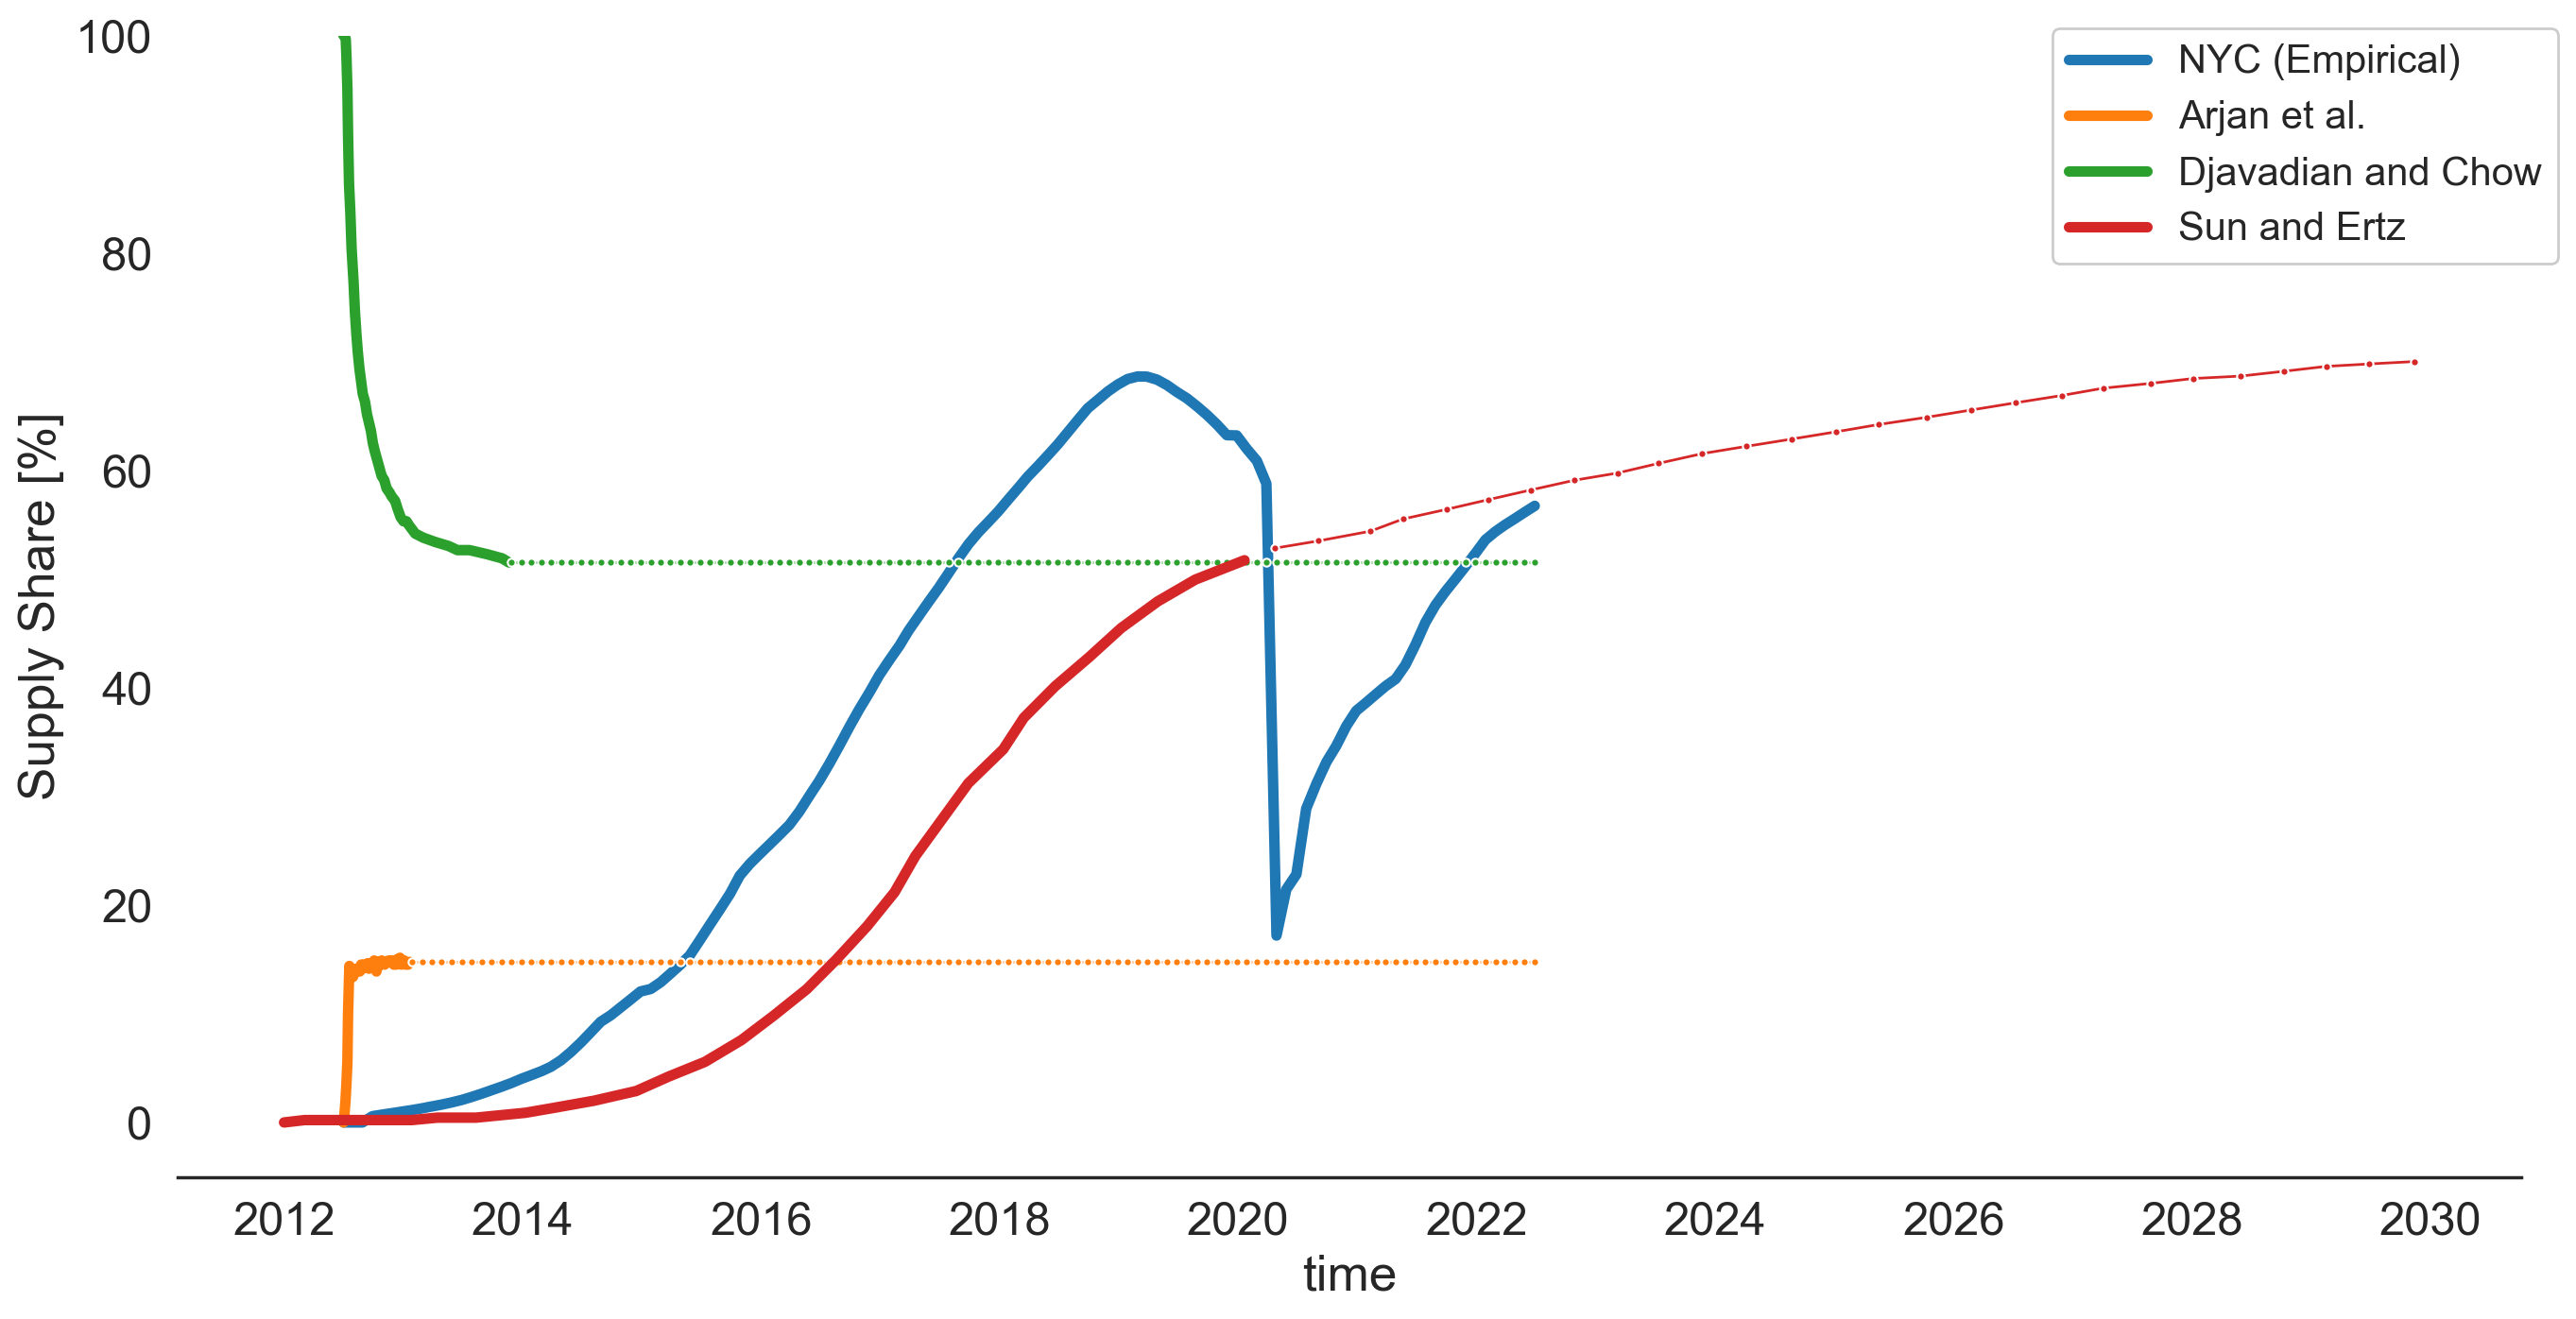

In [535]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('white')
fig, ax = plt.subplots(nrows=1, figsize=(16,8))
sns.despine(left=True)

nyc_max = nyc['Unique Dispatched Vehicles'].max()
nyc_smoothed = smooth(nyc['Unique Dispatched Vehicles'])
nyc_y = nyc_smoothed[0:89]+list(nyc[89:97]['Unique Dispatched Vehicles'])+nyc_smoothed[97:]
nyc_y = [0 if math.isnan(y) else y/nyc_max*100*0.7 for y in nyc_y]
# nyc_x = [x for x in range(1,len(nyc_y)+1)]
sns.lineplot(x=nyc.date, y=nyc_y,lw=4, label = 'NYC (Empirical)')

sns.lineplot(x=arjan.date, y=arjan.supply_share*100,lw=4, label = 'Arjan et al.', color='C1')
sns.lineplot(x=nyc.loc[6:].date, y=0.147727*100,lw=1, color='C1', marker = '.')

sns.lineplot(x=djavadian.date, y=djavadian.supply_share*100,lw=4, label = 'Djavadian and Chow', color='C2')
sns.lineplot(x=nyc.loc[16:].date, y=0.515152*100,lw=1, color='C2', marker = '.')



sns.lineplot(x=ertz.loc[0:29].date, y=ertz.loc[0:29].supply_share*100*0.7,lw=4, label = 'Sun and Ertz', color='C3')
sns.lineplot(x=ertz.loc[30:].date, y=ertz.loc[30:].supply_share*100*0.7,lw=1, color='C3', marker = '.')


ax.set(xlabel='time', ylabel='Supply Share [%]', ylim=(-5,100))
ax.legend(frameon=True,framealpha=1, loc=(0.8,0.8),fontsize=15)#,  bbox_to_anchor=(0.75, 1.24), ncol=4)


In [543]:
ams = pd.read_csv('data/Uber_Ams_2016-2022.csv')
ams

Unnamed: 0  Month  Number_of_drivers        date  Number_of_trips  \
0            0    2.0             1396.0  2016-02-28            94470   
1            1    3.0             1301.0  2016-03-28           106770   
2            2    4.0             1360.0  2016-04-28           119040   
3            3    5.0             1468.0  2016-05-28           130380   
4            4    6.0             1539.0  2016-06-28           132270   
..         ...    ...                ...         ...              ...   
74          74   76.0             4177.0  2022-04-28           461040   
75          75   77.0             4320.0  2022-05-28           475200   
76          76   78.0             4332.0  2022-06-28           488430   
77          77   79.0             4200.0  2022-07-28           427980   
78          78   80.0             3998.0  2022-08-28                0   

    Growth_index  
0           1.00  
1           1.13  
2           1.26  
3           1.38  
4           1.40  
..           ...  
74          4.88  
75          5.03  
76          5.17  
77          4.53  
78          0.00  

[79 rows x 6 columns]

In [ ]:
=======================================================================

<AxesSubplot:xlabel='date', ylabel='Number_of_trips'>

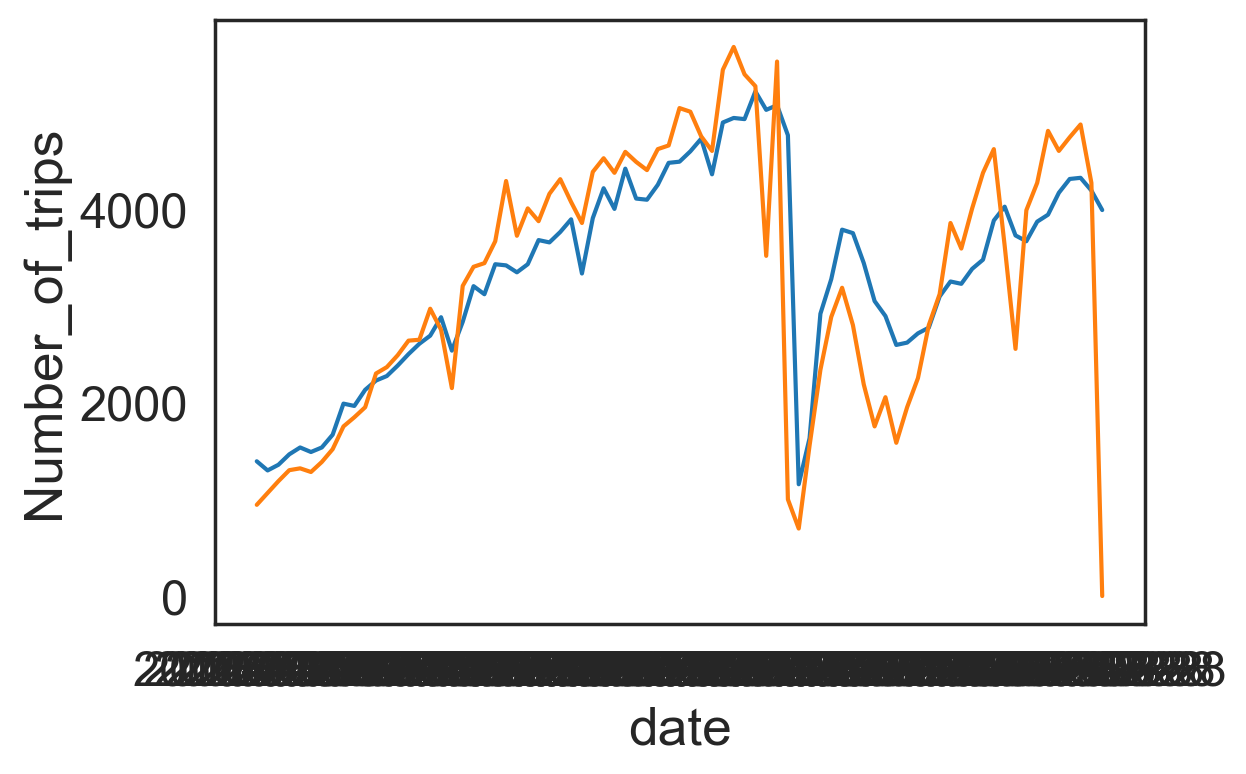

In [567]:
sns.lineplot(x=ams.date, y=ams.Number_of_drivers)
sns.lineplot(x=ams.date, y=ams.Number_of_trips/100)


In [564]:
ams

Unnamed: 0  Month  Number_of_drivers        date  Number_of_trips  \
0            0    2.0             1396.0  2016-02-28            94470   
1            1    3.0             1301.0  2016-03-28           106770   
2            2    4.0             1360.0  2016-04-28           119040   
3            3    5.0             1468.0  2016-05-28           130380   
4            4    6.0             1539.0  2016-06-28           132270   
..         ...    ...                ...         ...              ...   
74          74   76.0             4177.0  2022-04-28           461040   
75          75   77.0             4320.0  2022-05-28           475200   
76          76   78.0             4332.0  2022-06-28           488430   
77          77   79.0             4200.0  2022-07-28           427980   
78          78   80.0             3998.0  2022-08-28                0   

    Growth_index  
0           1.00  
1           1.13  
2           1.26  
3           1.38  
4           1.40  
..           ...  
74          4.88  
75          5.03  
76          5.17  
77          4.53  
78          0.00  

[79 rows x 6 columns]